In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
def grab_matrices(cq_file,nbasis):
    ''' Grabs the rotated density matrices and rotation angles 
        from a PHF output file from Chronus
    '''
    
    # determine the total number of grid points
    search_file = open(cq_file, "r")
    for line in search_file:
        if 'LebedevTrap Grid' in line:
            contents = re.split('\s+|\(|\)|\,',line)
            ngridT = int(contents[5])*int(contents[6])
    search_file.close()

    read_den = False
    angles, ang_dict = [], {}
    quaterions = ['Scalar', 'Mz', 'My', 'Mx']
    factor, ang_count, den_count, quat_ind = 1, -1, 0, 0
    den_arrays = np.zeros([ngridT,4,nbasis*nbasis],dtype=complex)
    search_file = open(cq_file, "r")
    for line in search_file:

        # collect the angles in a list of dictionaries
        if 'Alpha' in line:
            ang_dict = {}
            contents = re.split('\s+',line)
            ang_dict['alpha'] = float(contents[2])
        if 'Beta' in line:
            contents = re.split('\s+',line)
            ang_dict['beta'] = float(contents[2])
        if 'Gamma' in line:
            contents = re.split('\s+',line)
            ang_dict['gamma'] = float(contents[2])
            angles.append(ang_dict)
            ang_count += 1

        # determine what kind of density we're grabbing
        if 'Rot Density' in line:
            contents = re.split('\s+|\(|\)',line)
            quat_ind = quaterions.index(contents[3])
            if 'Re' in line:
                factor = 1
            else:
                factor = 1j
 
        # Grab densities from the output file
        if '-----' in line:
            read_den = not read_den
        if read_den:
            contents = re.split('\s+|--+',line)
            for element in contents:
                if 'e+' in element or 'e-' in element:
                    den_arrays[ang_count,quat_ind,den_count] += factor*float(element)
                    den_count += 1
        if not read_den:
            den_count = 0 

    search_file.close()

    # redimension the rot densities into matrices
    rot_dens = np.zeros([ngridT,4,nbasis,nbasis],dtype=complex)
    for g in range(ngridT):
        for q in range(4):
            ij = 0
            for i in range(nbasis):
                for j in range(nbasis):
                    rot_dens[g,q,i,j] = den_arrays[g,q,ij]
                    ij += 1                        

    # make list of angle labels
    ang_list = []
    for g in range(ngridT):
        string = "(%.2f,%.2f,%.2f)" % (angles[g]['alpha'], angles[g]['beta'], angles[g]['gamma'])
#        print angles[g]['gamma']
        ang_list.append(string)
        
#   print "rot den = \n", rot_dens[1,1].real
#   print angles[1]['alpha']

    return ngridT, angles, ang_list, rot_dens

In [4]:
cq_file = 'h3-sto3g-read-dense.out' 
nbasis  = 3
cq_file = 'o2-den-diff.out'
nbasis  = 18
ngridT, angles, ang_list, rot_dens = grab_matrices(cq_file,nbasis)

In [5]:
def euc_distance(rot_dens,ngridT):
    ''' Calculates the Euclidean distance between all the rotated densities
        and stores them in the matrix dist
    '''

    # calculate the euclidean distance between all rotated densities
    min_dist = []
    dist = np.zeros([4,ngridT,ngridT])
    for q in range(4):
        for g in range(ngridT):
            dist_min = 1000.
            dist_ind = g
            for h in range(g):
#               adiff = angles[g]['alpha'] - angles[h]['alpha']
#               bdiff = angles[g]['beta']  - angles[h]['beta']
#               gdiff = angles[g]['gamma'] - angles[h]['gamma']
                dist[q,g,h] = np.linalg.norm(rot_dens[g,q]-rot_dens[h,q],ord=-1)
#               dist[q,g,h] = np.linalg.norm(np.dot(rot_dens[g,q],rot_dens[h,q].T),'fro')
                if abs(dist[q,g,h]) < dist_min and g!=h:
                    dist_min = dist[q,g,h]
                    dist_ind = h
            if (g,dist_ind) not in min_dist and (dist_ind,g) not in min_dist:
                min_dist.append((g,dist_ind)) 
        dist[q] /= np.max(dist[q])
        
    return dist

In [6]:
def plot_euc_heatmap(dist):
    ''' Plots a heatmap of the Euclidean distances between rotated densities '''
    
    fig = plt.figure()

    plt.subplot(221)
    plt.imshow(dist[0], cmap='Blues', interpolation='nearest')
    plt.title("Scalar P")
    plt.colorbar()

    plt.subplot(222)
    plt.imshow(dist[1], cmap='Blues', interpolation='nearest')
    plt.title("Mz P")
    plt.colorbar()

    plt.subplot(223)
    plt.imshow(dist[2], cmap='Blues', interpolation='nearest')
    plt.title("My P")
    plt.colorbar()

    plt.subplot(224)
    plt.imshow(dist[3], cmap='Blues', interpolation='nearest')
    plt.title("Mx P")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


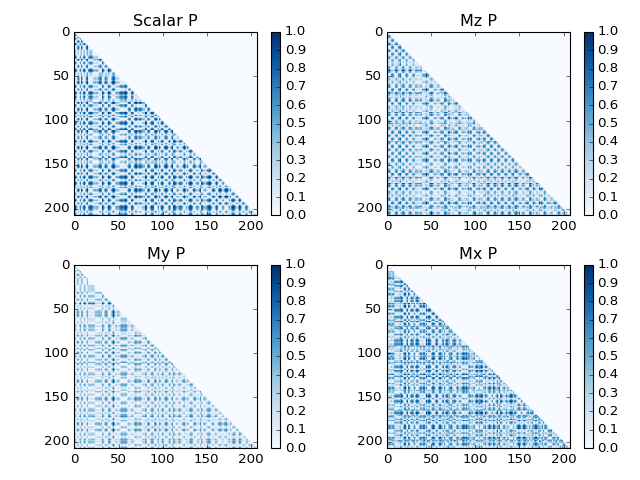

In [7]:
dist = euc_distance(rot_dens,ngridT)
#for i in range(ngridT):
#    print "dist = ", dist[0,i,0]
#print dist
plot_euc_heatmap(dist)

In [8]:
def plot_den_heatmap(rot_dens,angles):
    ''' Plots a heatmap of the rotated densities '''

    ngrid = 26
    nrows = 2
    start, end = nrows*32, nrows*34
    
    fig = plt.figure()
    nden = 1
    for i in range(start,end):
        plt.subplot(nrows+1,2,nden)
        plt.imshow(rot_dens[i][0].real, cmap='Blues', interpolation='nearest')
        plt.title("Scalar P: %d (%2.2f,%2.2f,%2.3f)" % 
                  (i, angles[i]['alpha'], angles[i]['beta'], angles[i]['gamma']))
        plt.colorbar()
        nden+=1
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure()
    nden = 1
    for i in range(start,end):
        plt.subplot(nrows+1,2,nden)
        plt.imshow(rot_dens[i][1].real, cmap='Blues', interpolation='nearest')
        plt.title("Mz P: %d (%2.2f,%2.2f,%2.3f)" 
                  % (i, angles[i]['alpha'], angles[i]['beta'], angles[i]['gamma']))
        plt.colorbar()
        nden+=1
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure()
    nden = 1
    for i in range(start,end):
        plt.subplot(nrows+1,2,nden)
        plt.imshow(rot_dens[i][2].real, cmap='Blues', interpolation='nearest')
        plt.title("My P: %d (%2.2f,%2.2f,%2.3f)" 
                  % (i, angles[i]['alpha'], angles[i]['beta'], angles[i]['gamma']))
        plt.colorbar()
        nden+=1
    plt.tight_layout()
    plt.show()
    

    fig = plt.figure()
    nden = 1
    for i in range(start,end):
        plt.subplot(nrows+1,2,nden)
        plt.imshow(rot_dens[i][3].real, cmap='Blues', interpolation='nearest')
        plt.title("Mx P: %d (%2.2f,%2.2f,%2.3f)" 
                  % (i, angles[i]['alpha'], angles[i]['beta'], angles[i]['gamma']))
        plt.colorbar()
        nden+=1
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


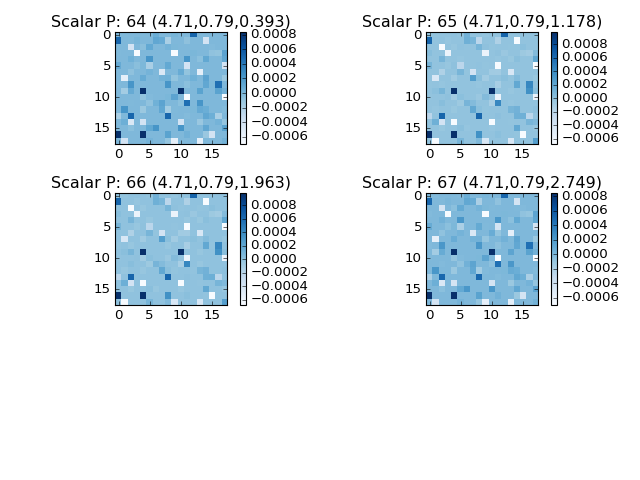

<IPython.core.display.Javascript object>


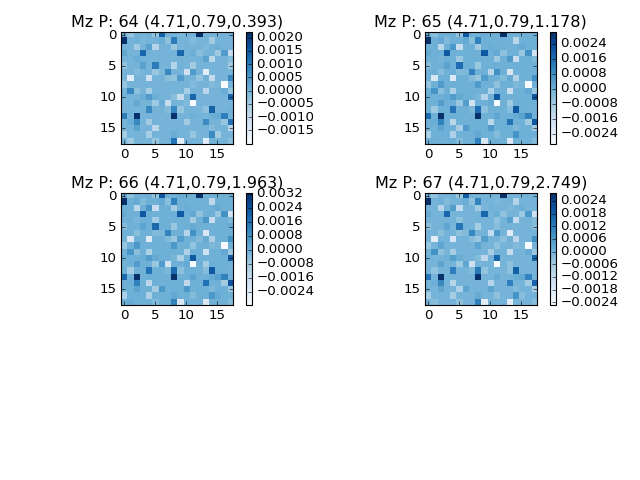

<IPython.core.display.Javascript object>


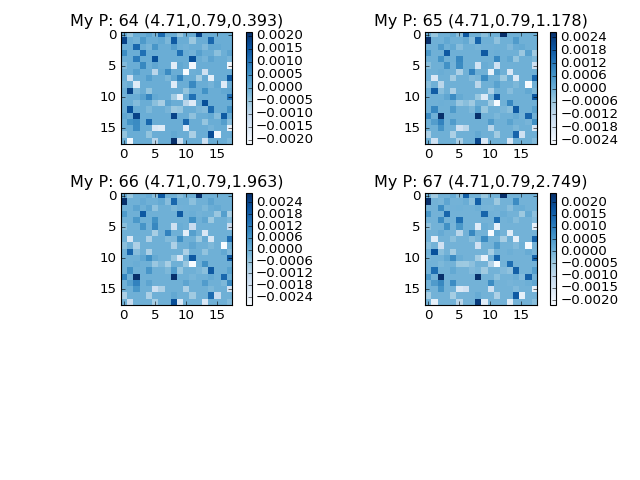

<IPython.core.display.Javascript object>


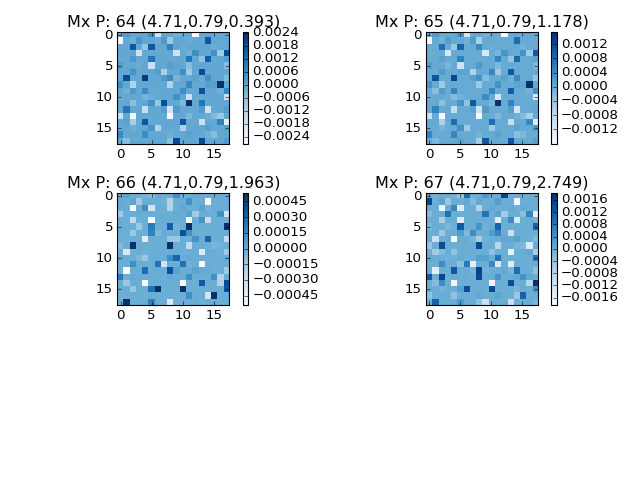

In [9]:
plot_den_heatmap(rot_dens,angles)

In [10]:
def plot_sphere_heatmap(dist,angles,ngridT,g_angle):
    ''' Plots the differences between rotated densities on a sphere '''

    plot_axis = 1
    nplots    = plot_axis**2
    nmod = int(26/nplots)
    thresh  = 1.e-3

    fig = plt.figure()

    # plot a unit sphere
    phi = np.linspace(0, 2 * np.pi, 26)
    theta = np.linspace(0, np.pi, 26)
    x = np.outer(np.cos(phi), np.sin(theta))
    y = np.outer(np.sin(phi), np.sin(theta))
    z = np.outer(np.ones(np.size(phi)), np.cos(theta))

    # define list of alpha/beta combinations to plot for a given gamma
    icount = 1
    ab_angs = []
    for g, angle in enumerate(angles):
        if abs(angle['gamma']-g_angle) < thresh:
            if icount % nmod == 0:
                ab_angs.append((angle['alpha'],angle['beta']))
            icount += 1
  
    icount = 1
    for a_angle, b_angle in ab_angs:
        ax = fig.add_subplot(plot_axis,plot_axis,icount, projection='3d')
#        ax.plot_surface(x, y, z, color='b',alpha=0.1)

        # define cartesian coordinates for alpha/beta with fixed gamma
        theta, phi = [], []
        for g, angle in enumerate(angles):
            if abs(angle['gamma']-g_angle) < thresh:
                phi.append(angle['alpha'])
                theta.append(angle['beta'])
        npoints = len(theta)
        xx = np.zeros([npoints])
        yy = np.zeros([npoints])
        zz = np.zeros([npoints])
        for i in range(npoints):
            if abs(phi[i] - a_angle) < thresh and abs(theta[i] - b_angle) < thresh:
                index = i
            xx[i] = np.sin(theta[i]) * np.cos(phi[i])
            yy[i] = np.sin(theta[i]) * np.sin(phi[i])
            zz[i] = np.cos(theta[i])
    
        # define difference color map for a fixed angle
        distances, d_index = [], []
        for g in range(ngridT):
            adiff = abs(angles[g]['alpha'] - a_angle)
            bdiff = abs(angles[g]['beta']  - b_angle)
            gdiff = abs(angles[g]['gamma'] - g_angle)
            if adiff < thresh and bdiff < thresh and gdiff < thresh:
                for h in range(ngridT):
                    gdiff = abs(angles[h]['gamma'] - g_angle)
                    if gdiff < thresh:
                        distances.append(dist[0,g,h])
                        d_index.append(h)

        v0 = np.sin(b_angle) * np.cos(a_angle)
        v1 = np.sin(b_angle) * np.sin(a_angle)
        v2 = np.cos(b_angle)
#       print a_angle, b_angle, g_angle, v0, v1, v2
        for g in range(len(distances)):
            angle = angles[d_index[g]]
            v0 = np.sin(angle['beta']) * np.cos(angle['alpha'])
            v1 = np.sin(angle['beta']) * np.sin(angle['alpha'])
            v2 = np.cos(angle['beta'])
#           print distances[g], angle, v0, v1, v2
        # plot lebedev points on sphere colored by Euclidean distances
        ax.set_title('(%.4f,%.4f,%.4f)' %(a_angle, b_angle, g_angle))
        ax.scatter(xx,yy,zz,c=distances,s=100,cmap='gray')
        ax.scatter(xx[index],yy[index],zz[index],color='red',s=200)
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_zlim([-1,1])
        ax.set_aspect("equal")
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')

        icount += 1

    plt.tight_layout()
    plt.show()
    
    return distances

<IPython.core.display.Javascript object>


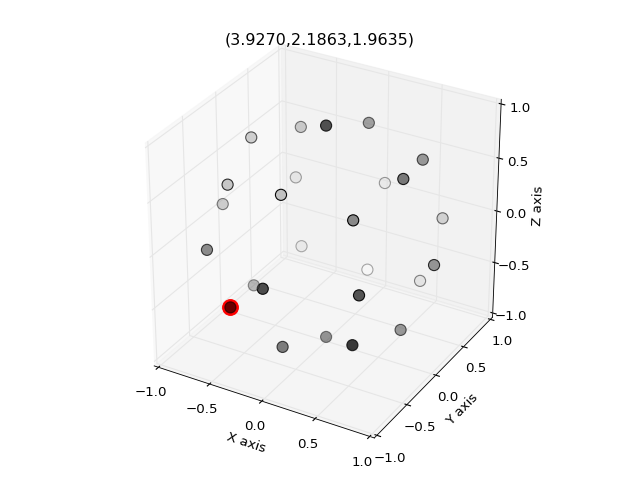

In [11]:
g_angle = 0.392699082 
#g_angle = 1.17809725
g_angle = 1.96349541
#g_angle = 2.74889357
#g_angle = 3.53429174
#g_angle = 4.3196899
#g_angle = 5.10508806
#g_angle = 5.89048623
distances = plot_sphere_heatmap(dist,angles,ngridT,g_angle)


In [12]:
def find_path_from_angles(dist,angles,ngridT,g_angle):
    ''' Tries to find a path through the densities by moving to the next
        closest angle. '''

    thresh  = 1.e-3

    # plot alpha/beta combinations for a given gamma
    ab_angs, ang_ind = [], []
    for g, angle in enumerate(angles):
        if abs(angle['gamma']-g_angle) < thresh:
            ab_angs.append((angle['alpha'],angle['beta']))
            ang_ind.append(g)
    npoints = len(ab_angs)

    # determine paths through the grid points
    icount = 0
    total_dist = 0.
    path = np.zeros([3,npoints])
    ang_path = [ab_angs[0]]
    v1, v2 = np.zeros([3]), np.zeros([3])
    while icount < 25:
        a_angle = ang_path[icount][0]
        b_angle = ang_path[icount][1]

        # define current cartesian point
        v1[0] = np.sin(b_angle) * np.cos(a_angle)
        v1[1] = np.sin(b_angle) * np.sin(a_angle)
        v1[2] = np.cos(b_angle)
        if icount == 0:
            path[0,icount], path[1,icount], path[2,icount] = v1[0], v1[1], v1[2]

        # find the shortest distance to the next one (not already in path)
        ind_ang = 0
        min_dist = 1000.
        for a2_angle, b2_angle in ab_angs:
            v2[0] = np.sin(b2_angle) * np.cos(a2_angle)
            v2[1] = np.sin(b2_angle) * np.sin(a2_angle)
            v2[2] = np.cos(b2_angle)
            found_dist = np.linalg.norm(v1-v2)
            if found_dist < min_dist and (a2_angle, b2_angle) not in ang_path:
                min_dist = found_dist
                euc_dist = dist[0,ang_ind[ind_ang],icount]
                min_angs = (a2_angle,b2_angle)
                path[0,icount+1], path[1,icount+1], path[2,icount+1] = v2[0], v2[1], v2[2]
            ind_ang += 1
        total_dist += euc_dist
        ang_path.append(min_angs)
        icount += 1

    return path, total_dist

In [13]:
def find_path_from_dist(dist,angles,ngridT,g_angle):
    ''' Tries to find a path through the densities by moving to the next
        density with the closest Euclidean distance. '''

    thresh  = 1.e-3

    # plot alpha/beta combinations for a given gamma
    ab_angs, ang_ind = [], []
    for g, angle in enumerate(angles):
        if abs(angle['gamma']-g_angle) < thresh:
            ab_angs.append((angle['alpha'],angle['beta']))
            ang_ind.append(g)
    npoints = len(ab_angs)
 
    # define difference color map for a fixed angle
    a_angle = ab_angs[0][0]
    b_angle = ab_angs[0][1]
    distances, d_index = [], []
    for g in range(ngridT):
        adiff = abs(angles[g]['alpha'] - a_angle)
        bdiff = abs(angles[g]['beta']  - b_angle)
        gdiff = abs(angles[g]['gamma'] - g_angle)
        if adiff < thresh and bdiff < thresh and gdiff < thresh:
            for h in range(ngridT):
                gdiff = abs(angles[h]['gamma'] - g_angle)
                if gdiff < thresh:
                    distances.append(dist[0,h,g])
                    d_index.append(h)
                    
    # determine paths through the grid points based on density diffs.
    icount = 0
    total_dist = 0.
    path = np.zeros([3,npoints])
    ang_path = [ab_angs[0]]
    v1, v2 = np.zeros([3]), np.zeros([3])
    while icount < 25:
        a_angle = ang_path[icount][0]
        b_angle = ang_path[icount][1]

        # define current cartesian point
        v1[0] = np.sin(b_angle) * np.cos(a_angle)
        v1[1] = np.sin(b_angle) * np.sin(a_angle)
        v1[2] = np.cos(b_angle)
        if icount == 0:
            path[0,icount], path[1,icount], path[2,icount] = v1[0], v1[1], v1[2]
            
#       # find the shortest distance to the next one (not already in path)
        ind_ang = 0
        min_dist = 1000.
        for a2_angle, b2_angle in ab_angs:
            v2[0] = np.sin(b2_angle) * np.cos(a2_angle)
            v2[1] = np.sin(b2_angle) * np.sin(a2_angle)
            v2[2] = np.cos(b2_angle)
            found_dist = dist[0,ang_ind[ind_ang],icount]
            if found_dist < min_dist and (a2_angle, b2_angle) not in ang_path:
                min_dist = found_dist
                min_angs = (a2_angle,b2_angle)
                path[0,icount+1], path[1,icount+1], path[2,icount+1] = v2[0], v2[1], v2[2]
            ind_ang += 1
        total_dist += min_dist
        ang_path.append(min_angs)
        icount += 1

    return path, total_dist, distances

In [14]:
def plot_paths(a_path,d_path,angles,distances):
    ''' Plot paths along a sphere as determined in other routines. '''

    thresh = 1.e-3
    fig = plt.figure()

    # plot a unit sphere
    phi = np.linspace(0, 2 * np.pi, 50)
    theta = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(phi), np.sin(theta))
    y = np.outer(np.sin(phi), np.sin(theta))
    z = np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(x, y, z, color='b',alpha=0.1)

    # plot alpha/beta combinations for a given gamma
    ab_angs, ang_ind = [], []
    for g, angle in enumerate(angles):
        if abs(angle['gamma']-g_angle) < thresh:
            ab_angs.append((angle['alpha'],angle['beta']))
            ang_ind.append(g)
    npoints = len(ab_angs)
    xx, yy, zz = np.zeros([npoints]), np.zeros([npoints]), np.zeros([npoints])
    for i, angle in enumerate(ab_angs):
        xx[i] = np.sin(angle[1]) * np.cos(angle[0])
        yy[i] = np.sin(angle[1]) * np.sin(angle[0])
        zz[i] = np.cos(angle[1])
    ax.scatter(xx,yy,zz,c=distances,s=100,cmap='gray')
    ax.scatter(xx[0],yy[0],zz[0],color='red',s=200)

    ax.plot(a_path[0],a_path[1],a_path[2])
    ax.plot(d_path[0],d_path[1],d_path[2],color='green')

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_aspect('equal')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.tight_layout()
    plt.title("Gamma = %.4f" % g_angle)
    plt.show()

Gamma      =  0.392699082
Angle-Dist =  8.05488869276
Euc-Dist   =  1.77709694815


<IPython.core.display.Javascript object>


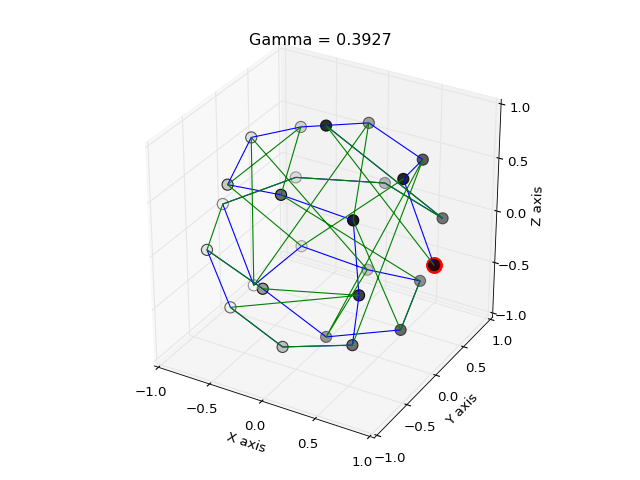

In [15]:
g_angle = 0.392699082 
a_path, total_dist1 = find_path_from_angles(dist,angles,ngridT,g_angle)
d_path, total_dist2, colors = find_path_from_dist(dist,angles,ngridT,g_angle)
print "Gamma      = ", g_angle
print "Angle-Dist = ", total_dist1
print "Euc-Dist   = ", total_dist2
plot_paths(a_path,d_path,angles,colors)

In [16]:
def q_slerp(v0,v1,t):
    '''Interpolate between two quaternions'''  
    
    dot = 0.
    for i in range(4):
        dot += v0[i]*v1[i]

    # if they're too close, linearly interpolate
    dot_thresh = 0.9995
    if dot > dot_thresh:
        slerp = v0 * t*(v1 - v0)
        slerp /= np.linalg.norm(slerp)

    # Find slerp
    else: 
        if dot < 0:
            v1 = -v1
            dot = -dot
            
        # clamp dot product to right range
        max(min(dot, 1.), -1)
        theta_0 = np.arccos(dot)
        theta = theta_0 * t
     
        v2 = v1 - v0*dot
        v2 /= np.linalg.norm(v2)
    
        slerp = v0*np.cos(theta) + v2*np.sin(theta)

    return slerp

def quaternion_rep(angles,ngridT):
    '''Define the quaternion representation of the Euler angles'''
    
    quats     = np.zeros([ngridT,4])
    q_angles  = np.zeros([ngridT,ngridT])
    slerp_len = np.zeros([ngridT,ngridT])

    # transform euler angles to unit quaternions
    for g, angle in enumerate(angles):
        quats[g,0] = ( np.cos(angle['beta']/2) *
                       np.cos((angle['alpha']+angle['gamma'])/2) )
        quats[g,1] = (-np.sin(angle['beta']/2) *
                       np.sin((angle['alpha']-angle['gamma'])/2) )
        quats[g,2] = ( np.sin(angle['beta']/2) *
                       np.cos((angle['alpha']-angle['gamma'])/2) )
        quats[g,3] = ( np.cos(angle['beta']/2) *
                       np.sin((angle['alpha']+angle['gamma'])/2) )

    # evaluate angles between all unit quaternions ensuring we're going the short way
    for g in range(ngridT):
        for h in range(g):
#           q_angles[g,h] = 2*np.arccos(np.abs(np.dot(quats[g],quats[h])))
            q_angles[g,h] = np.arccos(2*np.dot(quats[g],quats[h])**2 - 1)

    # integrate over rotation to get arc length
    nslerp = 10
    for g in range(ngridT):
        for h in range(g):
            # smoothly iterpolate between two quaternions (slerp)
            ang = q_angles[g,h]
            for i in range(nslerp-1):
                t = float(i)/float(nslerp)
                slerp1 = q_slerp(quats[g],quats[h],t)
                t = float(i+1)/float(nslerp)
                slerp2 = q_slerp(quats[g],quats[h],t)
                slerp_len[g,h] += np.linalg.norm(slerp1-slerp2)
                
    return quats, q_angles, slerp_len

In [17]:
def plot_quaternion_angles(dist,q_angles,slerp_len):

    fig = plt.figure()

    plt.subplot(131)
    plt.imshow(dist[0], cmap='Blues', interpolation='nearest')
    plt.title("Scalar P")
    plt.colorbar()

    plt.subplot(132)
    plt.imshow(2*q_angles, cmap='Blues', interpolation='nearest')
    plt.title("Quaternion Angles")
    plt.colorbar()

    plt.subplot(133)
    plt.imshow(slerp_len, cmap='Blues', interpolation='nearest')
    plt.title("Arc Lengths")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


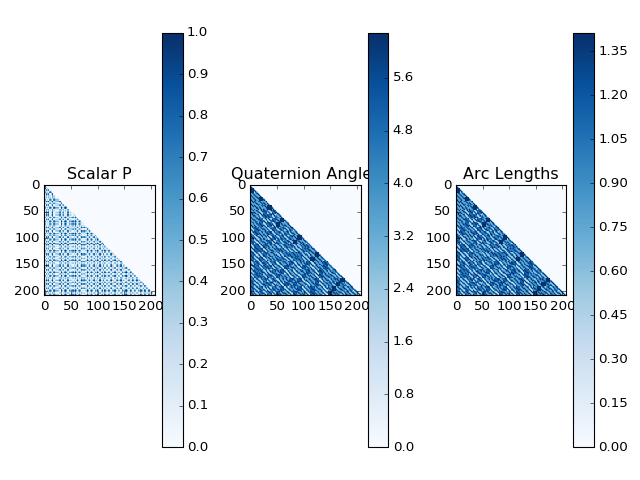

In [18]:
quats, q_angles, slerp_len = quaternion_rep(angles,ngridT)
plot_quaternion_angles(dist,q_angles,slerp_len)

<IPython.core.display.Javascript object>


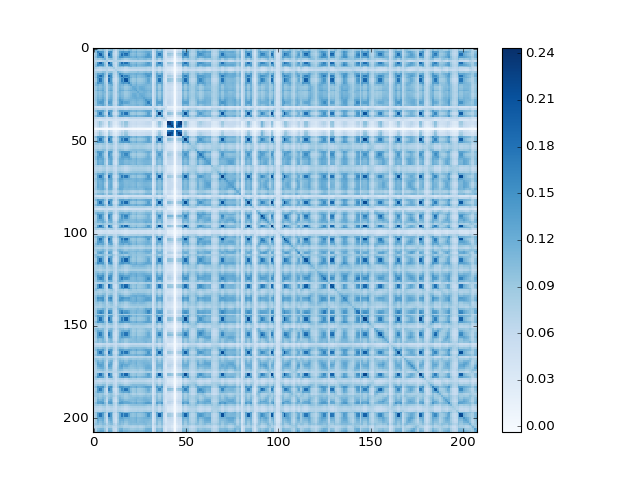

In [19]:
# Find all the shell pairs not screened by all grid points
not_all = []
unique_file = open('shell-pairs/c4_alcohol_unique_shells.txt', 'r')
for i, line in enumerate(unique_file):
    contents = re.split(',',re.split(':',line)[1].rstrip())
    if len(contents) < ngridT and len(contents) > 1:
        not_all.append(line)
unique_file.close()

# make a matrix of the angles and which shell pairs they screen
shell_grid = np.zeros([ngridT,len(not_all)])
for i, shell in enumerate(not_all):
    contents = re.split(',',re.split(':',shell)[1].rstrip())
    for grid in contents:
        shell_grid[int(grid),i] = 1

# build a correlation matrix between the grid points
fig = plt.figure()
plt.imshow(np.cov(shell_grid), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

In [20]:
C = np.cov(shell_grid)
n_clusters = 8
cluster_size = ngridT / n_clusters

def score(C):
    '''
    Function to assign a score to an ordered covariance matrix.
    High correlations within a cluster improve the score.
    High correlations between clusters decease the score.
    '''
    score = 0
    for cluster in range(n_clusters):
        inside_cluster = np.arange(cluster_size) + cluster * cluster_size
        outside_cluster = np.setdiff1d(range(ngridT), inside_cluster)

        # Belonging to the same cluster
        score += np.sum(C[inside_cluster, :][:, inside_cluster])

        # Belonging to different clusters
        score -= np.sum(C[inside_cluster, :][:, outside_cluster])
        score -= np.sum(C[outside_cluster, :][:, inside_cluster])

    return score


initial_C = C
initial_score = score(C)
initial_ordering = np.arange(ngridT)

In [21]:
# Pretty dumb greedy optimization algorithm that continuously
# swaps rows to improve the score
def swap_rows(C, var1, var2):
    '''
    Function to swap two rows in a covariance matrix,
    updating the appropriate columns as well.
    '''
    D = C.copy()
    D[var2, :] = C[var1, :]
    D[var1, :] = C[var2, :]

    E = D.copy()
    E[:, var2] = D[:, var1]
    E[:, var1] = D[:, var2]

    return E

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 100
for i in range(max_iter):
    print(i)
    # Find the best row swap to make
    best_C = current_C
    best_ordering = current_ordering
    best_score = current_score
    for row1 in range(ngridT):
        for row2 in range(ngridT):
            if row1 == row2:
                continue
            option_ordering = best_ordering.copy()
            option_ordering[row1] = best_ordering[row2]
            option_ordering[row2] = best_ordering[row1]
            option_C = swap_rows(best_C, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C = option_C
                best_ordering = option_ordering
                best_score = option_score

    print("Current Score: "+str(current_score))
    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C
        current_ordering = best_ordering
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break

0
Current Score: -6395.37802552
1
Current Score: -6063.6674104
2
Current Score: -6058.10914555
3
Current Score: -6055.79713399
4
Current Score: -6054.6136711


<IPython.core.display.Javascript object>


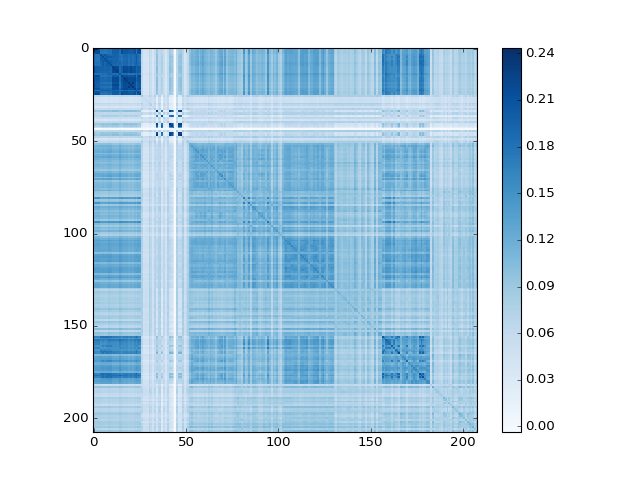

In [22]:
fig = plt.figure()
plt.imshow(best_C, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


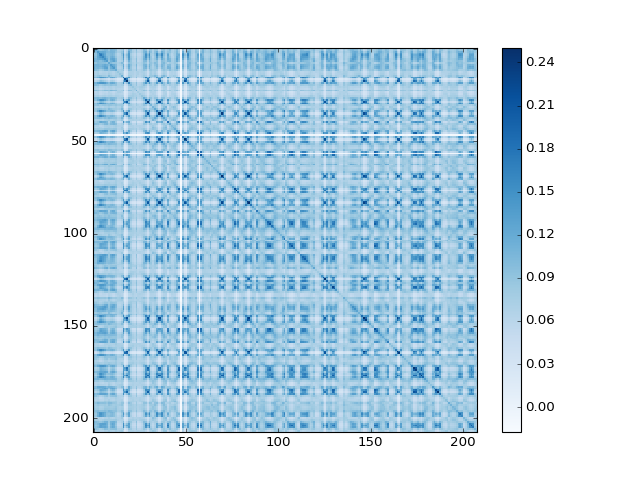

In [23]:
# Find all the shell pairs not screened by all grid points
not_all = []
unique_file = open('shell-pairs/c4_fromUHF_unique_shells.txt', 'r')
for i, line in enumerate(unique_file):
    contents = re.split(',',re.split(':',line)[1].rstrip())
    if len(contents) < ngridT and len(contents) > 1:
        not_all.append(line)
unique_file.close()

# make a matrix of the angles and which shell pairs they screen
shell_grid = np.zeros([ngridT,len(not_all)])
for i, shell in enumerate(not_all):
    contents = re.split(',',re.split(':',shell)[1].rstrip())
    for grid in contents:
        shell_grid[int(grid),i] = 1

# build a correlation matrix between the grid points
fig = plt.figure()
plt.imshow(np.cov(shell_grid), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

In [24]:
C = np.cov(shell_grid)
initial_C = C
initial_score = score(C)
initial_ordering = np.arange(ngridT)

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 100
for i in range(max_iter):
    print(i)
    # Find the best row swap to make
    best_C2 = current_C
    best_ordering2 = current_ordering
    best_score = current_score
    for row1 in range(ngridT):
        for row2 in range(ngridT):
            if row1 == row2:
                continue
            option_ordering = best_ordering2.copy()
            option_ordering[row1] = best_ordering2[row2]
            option_ordering[row2] = best_ordering2[row1]
            option_C = swap_rows(best_C2, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C2 = option_C
                best_ordering2 = option_ordering
                best_score = option_score

    print("Current Score: "+str(current_score))
    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C2
        current_ordering = best_ordering2
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break

0
Current Score: -5772.1329752
1
Current Score: -5278.83617889
2
Current Score: -5265.75165343


In [35]:
# Find all the shell pairs not screened by all grid points
not_all = []
unique_file = open('shell-pairs/c4_unique_shells.txt', 'r')
for i, line in enumerate(unique_file):
    contents = re.split(',',re.split(':',line)[1].rstrip())
    if len(contents) < ngridT and len(contents) > 1:
        not_all.append(line)
unique_file.close()

# make a matrix of the angles and which shell pairs they screen
shell_grid = np.zeros([ngridT,len(not_all)])
for i, shell in enumerate(not_all):
    contents = re.split(',',re.split(':',shell)[1].rstrip())
    for grid in contents:
        shell_grid[int(grid),i] = 1

C = np.cov(shell_grid)
initial_C = C
initial_score = score(C)
initial_ordering = np.arange(ngridT)

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 100
for i in range(max_iter):
    print(i)
    # Find the best row swap to make
    best_C3 = current_C
    best_ordering3 = current_ordering
    best_score = current_score
    for row1 in range(ngridT):
        for row2 in range(ngridT):
            if row1 == row2:
                continue
            option_ordering = best_ordering3.copy()
            option_ordering[row1] = best_ordering3[row2]
            option_ordering[row2] = best_ordering3[row1]
            option_C = swap_rows(best_C3, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C3 = option_C
                best_ordering3 = option_ordering
                best_score = option_score

    print("Current Score: "+str(current_score))
    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C3
        current_ordering = best_ordering3
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break

0
Current Score: -8776.79625141
1
Current Score: -7579.38537532
2
Current Score: -7570.32818497
3
Current Score: -7570.1856772


<IPython.core.display.Javascript object>


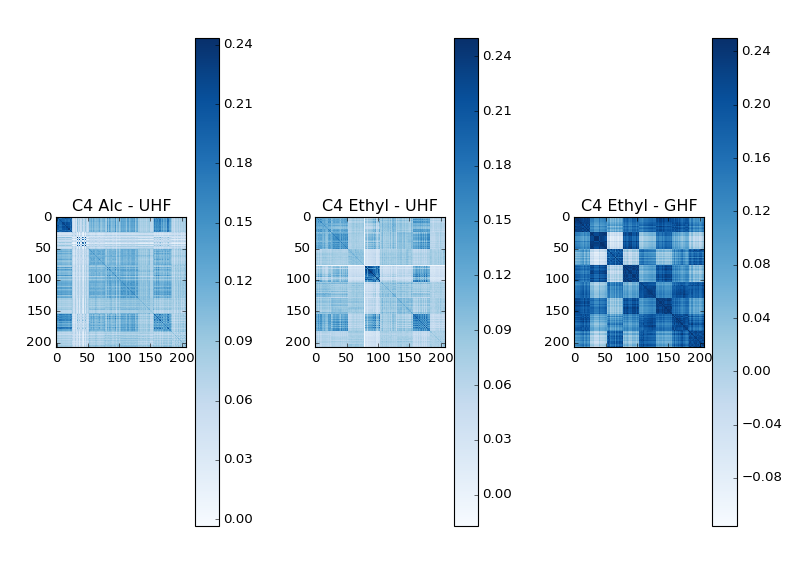

In [42]:
fig = plt.figure()

plt.subplot(131)
plt.imshow(best_C, cmap='Blues', interpolation='nearest')
plt.title("C4 Alc - UHF")
plt.colorbar()

plt.subplot(132)
plt.imshow(best_C2, cmap='Blues', interpolation='nearest')
plt.title("C4 Ethyl - UHF")
plt.colorbar()

plt.subplot(133)
plt.imshow(best_C3, cmap='Blues', interpolation='nearest')
plt.title("C4 Ethyl - GHF")
plt.colorbar()

plt.tight_layout()
plt.show()

In [47]:
#for i in range(n_clusters):
#    cluster = best_ordering3[i*26:(i+1)*26]
#    best_ordering3[i*26:(i+1)*26] = np.sort(cluster)
    
print best_ordering[26*5:26*6]
print best_ordering2[:26]
print best_ordering3[:26]

[  6  21  22  25  26  52  53  54  55  64  66  67 118 119 121 133 137 138
 139 149 150 151 162 181 182 193]
[  6   7   9  10  11  45  63  75  78  88  93 105 108 112 131 139 140 154
 158 159 172 175 184 187 203 205]
[  0   1   2   5   6   7  11  12  13  19  20  21  27  28  29  30 115 117
 118 122 123 125 131 133 139 141]


In [3]:
def grab_matrices2(cq_file,nbasis):
    ''' Grabs the rotated density matrices and rotation angles 
        from a PHF output file from Chronus
    '''
    
    # determine the total number of grid points
    search_file = open(cq_file, "r")
    for line in search_file:
        if 'LebedevTrap Grid' in line:
            contents = re.split('\s+|\(|\)|\,',line)
            ngridT = int(contents[5])*int(contents[6])
    search_file.close()

    read_den = False
    angles, ang_dict = [], {}
    quaterions = ['Scalar', 'Mz', 'My', 'Mx']
    factor, ang_count, den_count, quat_ind = 1, -1, 0, 0
    den_arrays = np.zeros([4*ngridT,4,nbasis*nbasis],dtype=complex)
    search_file = open(cq_file, "r")
    for line in search_file:

        # collect the angles in a list of dictionaries
        if 'Alpha' in line:
            ang_dict = {}
            contents = re.split('\s+',line)
            ang_dict['alpha'] = float(contents[2])
        if 'Beta' in line:
            contents = re.split('\s+',line)
            ang_dict['beta'] = float(contents[2])
        if 'Gamma' in line:
            contents = re.split('\s+',line)
            ang_dict['gamma'] = float(contents[2])
            angles.append(ang_dict)
            ang_count += 1

        # determine what kind of density we're grabbing
        if 'Rot Density' in line:
            contents = re.split('\s+|\(|\)',line)
            quat_ind = quaterions.index(contents[3])
            if 'Re' in line:
                factor = 1
            else:
                factor = 1j
 
        # Grab densities from the output file
        if '-----' in line:
            read_den = not read_den
        if read_den:
            contents = re.split('\s+|--+',line)
            for element in contents:
                if 'e+' in element or 'e-' in element:
                    den_arrays[ang_count,quat_ind,den_count] += factor*float(element)
                    den_count += 1
        if not read_den:
            den_count = 0 

    search_file.close()

    # redimension the rot densities into matrices
    rot_dens = np.zeros([4*ngridT,4,nbasis,nbasis],dtype=complex)
    for g in range(4*ngridT):
        for q in range(4):
            ij = 0
            for i in range(nbasis):
                for j in range(nbasis):
                    rot_dens[g,q,i,j] = den_arrays[g,q,ij]
                    ij += 1                        

    # make list of angle labels
    ang_list = []
    for g in range(ngridT):
        string = "(%.2f,%.2f,%.2f)" % (angles[g]['alpha'], angles[g]['beta'], angles[g]['gamma'])
#        print angles[g]['gamma']
        ang_list.append(string)
        
#   print "rot den = \n", rot_dens[1,1].real
#   print angles[1]['alpha']

    return ngridT, angles, ang_list, rot_dens

In [4]:
cq_file = 'o2-631g-read-2steps.out'
nbasis  = 18
ngridT, angles, ang_list, rot_dens = grab_matrices2(cq_file,nbasis)

In [5]:
def gather(p_s,p_z,p_y,p_x,n):
    
    p = np.zeros([2*n,2*n],dtype=complex)
    
    p_aa = 0.5 * (p_s +    p_z)
    p_bb = 0.5 * (p_s -    p_z)
    p_ba = 0.5 * (p_x + 1j*p_y)
    p_ab = 0.5 * (p_x - 1j*p_y)
    
    for i in range(n):
        for j in range(n):
            p[2*i,2*j]     = p_aa[i,j]
            p[2*i,2*j+1]   = p_ab[i,j]
            p[2*i+1,2*j]   = p_ba[i,j]
            p[2*i+1,2*j+1] = p_bb[i,j]

    return p

In [15]:
# Gather all matrices together
densities = []
for i, dens in enumerate(rot_dens):
    densities.append(gather(dens[0],dens[1],dens[2],dens[3],nbasis))

In [68]:
# collect densities from each iteration
scfit = [[] for _ in range(4)]
for i in range(3):
    scfit[i] = densities[(i+1)*208:(i+2)*208]
    
# collect density differences
dendiff = [[] for _ in range(3)]
for i in range(2):
    for j in range(208):
        dendiff[i].append(scfit[i+1][j] - scfit[i][j])

# Grab the initial active densities
p_a = []
for i in range(208):
    p_a.append(scfit[0][i])

In [86]:
#for i in range(208):
for i in range(1):
    nsize = 5
    
    # Solve system of linear equations
    A = np.zeros([nsize,nsize],dtype=complex)
    b = np.zeros([nsize],dtype=complex)
    for j in range(nsize):
        for h in range(nsize):
            A[j,h] = np.trace(p_a[i+j].dot(p_a[i+h]))
        b[j] = np.trace(p_a[i+j].dot(scfit[1][i]))    
    x = np.linalg.solve(A,b)
    print np.allclose(np.dot(A, x), b)

    # Find the 'active' part of the density at this grid point
    p_i = np.zeros([2*nbasis,2*nbasis],dtype=complex)
    for j in range(nsize):
        p_i += x[j] * p_a[i+j]
    new_p_a = scfit[1][i] - p_i
    
    print dendiff[1][i].real[:4,:4]
    print new_p_a.real[:]
    # Check whether the density difference or 'active' density is greater
    print "Den Diff = ", max(np.amax(dendiff[1][i]), np.amin(dendiff[1][i]), key=abs), np.linalg.norm(dendiff[1][i])
    print "Active   = ", max(np.amax(new_p_a), np.amin(new_p_a), key=abs), np.linalg.norm(new_p_a)


True
[[ 0.00151003 -0.00044615  0.01630628  0.00365887]
 [ 0.00162166  0.00165997 -0.00792834  0.00584886]
 [-0.06172742 -0.01572728  0.02846371 -0.01115159]
 [ 0.05142991 -0.01690755 -0.02827659 -0.04207219]]
Den Diff =  (-0.1689544965+0.02495964695j) 1.62992513758
Active   =  (-0.409209733949+0.541483987383j) 6.05921378915
